# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [32]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import Dataset, DataLoader, Dataset

EPS = 1.0e-7

In [33]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# mount drive: WE NEED IT FOR SAVING IMAGES!
# from google.colab import drive

# drive.mount("/content/gdrive")

In [34]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
# results_dir = "/content/gdrive/My_Drive/Colab Notebooks/TEACHING/"

In [35]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train": 
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx] # Target is not transformed
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

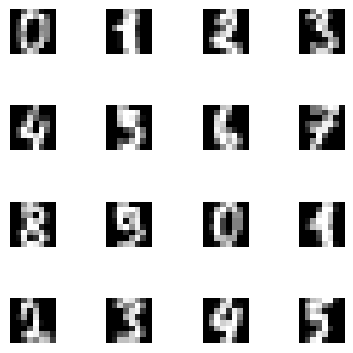

In [36]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [37]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [38]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        
        # Forward pass
        output = self.classnet(x)
        # Apply argmax to the output
        y_pred = torch.argmax(output, dim=1)
        
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        output = self.classnet(x)
        output = F.log_softmax(output, dim=1)
        loss = self.nll(output, y)
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:** The objective function, namely, the loss function NLLLoss stands for Negative Log-Likelihood Loss with reduction = `None`, whose mathematical terms are defined by:
$ \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, l_n = - w_{y_n} x_{n,y_n}, 
        w_{c} = \text{weight}[c] \cdot \mathbb{1}\{c \not= \text{ignore\_index}\},
$
where `x` is the input, `y` is the target, `w` is the weight, and `N` is the batch size.

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** Applying `log-softmax` will give identical results to `softmax` actication function, since they both give the indices of maximum values. `softmax` transforms the output to probability distribution, and `log-softmax` transforms the output to logarithmic probability distribution. Both functions give same results of picking the most probable labels. Logarithmic probability provides better stability with small values.

### 2.2 Evaluation

In [39]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [40]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [41]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [42]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [43]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [44]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.

In [45]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join("./model/", "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./model/"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            nn.Linear(D, M),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer
            nn.Linear(M, M),  # Another linear layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(M, K),
            nn.LogSoftmax(dim=1)  # LogSoftmax for the output
        )
        pass

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            Reshape((1, 8, 8)),
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, K),
            nn.LogSoftmax(dim=1),
        )
        pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )


-> START classifier_mlp
Epoch: 0, val nll=1.375830808367048, val ce=0.18285714285714286


Epoch: 10, val nll=0.1871129185812814, val ce=0.05714285714285714
Epoch: 20, val nll=0.13360636506761822, val ce=0.04285714285714286
Epoch: 30, val nll=0.11008203438350132, val ce=0.03142857142857143


KeyboardInterrupt: 

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: The results of MLP in terms of loss function and classification error are given by:  
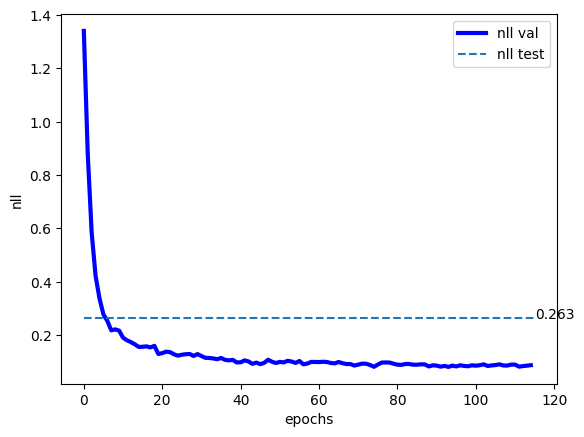 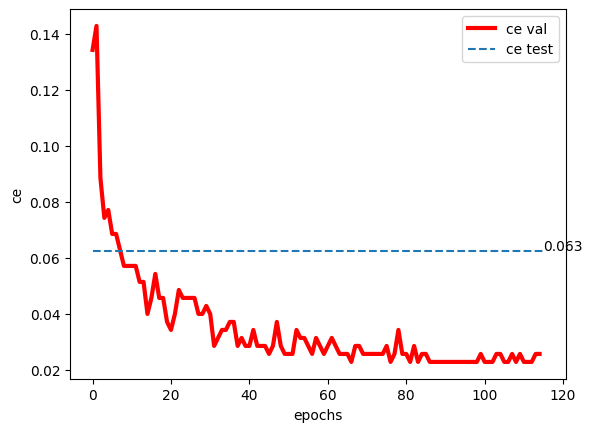
The results of CNN in terms of loss function and classification error are given by:  
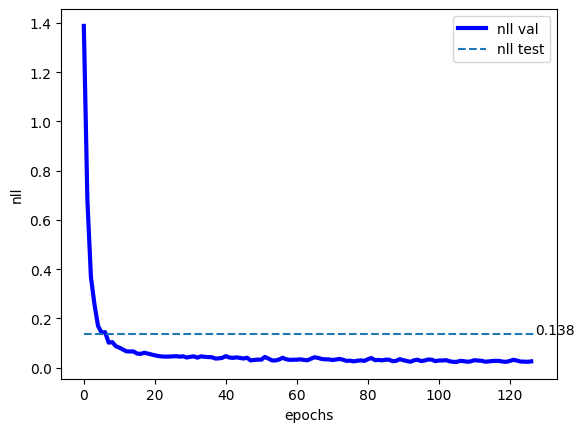 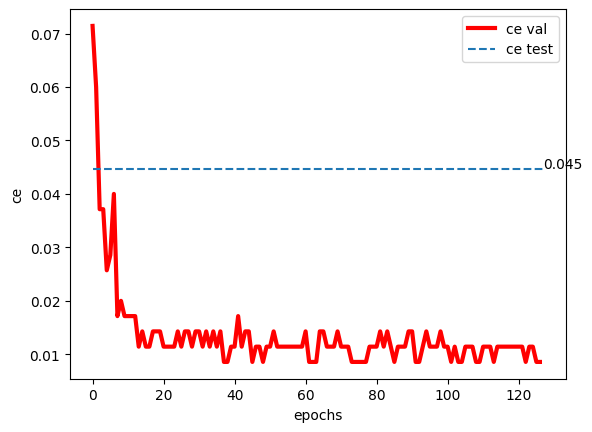
We have found that the overall performance of CNN is much stronger than MLP, while MLP is more capable of stabilizing with fewer epochs than CNN. CNN tends to converge to a stable result around 50 epochs, and MLP tends to converge around 80 epochs.

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: For the first question, the answer is ```No```. In the very first versions of two models, the MLP performed better than CNN in terms of classification error. With further modification of the models (e.g.: adding dropout and more convolution layers), the CNN outperformed MLP. CNNs are able to handle the spatial hierarchy of image data more efficiently and recognize local features in an image, such as edges, textures, and shapes, by using a convolutional layer that is captured by a small window of locally-connected weights, which makes it possible to maintain the spatial hierarchical nature of the image and reduce the number of model parameters. This property makes CNNs particularly suitable for image data because they require fewer parameters to process image inputs of the same size and are more robust to geometric transformations in the image than the fully connected layers of an MLP.

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import h5py
import PIL.Image as Image
from torchvision import transforms

batch_size = 8192
image_size = (32, 32)

# Transform
transform = transforms.Compose(
    [
        transforms.Resize(image_size),  # Resize the image to 32x32
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)


class SVHNDataset(Dataset):
    def __init__(self, root_dir, mode="train", transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.data_files = self._load_data_files()
        self.labels = self._load_labels()

        if self.mode == "train":
            self.validation_split = int(0.2 * len(self.data_files))
            self.train_files = self.data_files[self.validation_split :]
            self.val_files = self.data_files[: self.validation_split]
        elif self.mode == "val":
            self.validation_split = int(0.2 * len(self.data_files))
            self.val_files = self.data_files[: self.validation_split]
        else:
            self.train_files = self.data_files

    def _load_data_files(self):
        if self.mode in ["train", "val"]:
            data_path = os.path.join(self.root_dir, "train")
        elif self.mode == "test":
            data_path = os.path.join(self.root_dir, "test")
        else:
            raise ValueError("Mode must be 'train', 'test' or 'val'")

        # 只添加图像文件到data_files列表中
        return [
            os.path.join(data_path, file)
            for file in os.listdir(data_path)
            if os.path.splitext(file)[1] in [".png", ".jpg", ".jpeg"]
        ]

    def _load_labels(self):
        labels = []
        if self.mode in ["train", "test"]:
            file_path = os.path.join(self.root_dir, self.mode, "digitStruct.mat")
        elif self.mode == "val":
            file_path = os.path.join(self.root_dir, "train", "digitStruct.mat")
        else:
            raise ValueError("Mode must be 'train', 'test' or 'val'")
        mat = h5py.File(file_path, "r")

        num_bboxes = len(mat["digitStruct"]["bbox"])

        for i in range(len(self.data_files)):
            if i < num_bboxes:
                bbox = self.read_bbox(mat, i)
                labels.append(bbox["label"])

        return labels

    def read_bbox(self, file, index):
        bbox = {}
        item = file[file["digitStruct"]["bbox"][index][0]]
        for key in ["label", "left", "top", "width", "height"]:
            attr = item[key]
            if len(attr) > 1:
                bbox[key] = [file[attr[i][0]][0][0] for i in range(len(attr))]
            else:
                bbox[key] = [attr[0][0]]
        bbox["label"] = [int(l) for l in bbox["label"]]
        return bbox

    def __len__(self):
        if self.mode == "train":
            return len(self.train_files)
        elif self.mode == "val":
            return len(self.val_files)
        else:
            return len(self.data_files)

    def __getitem__(self, idx):
        if self.mode == "train":
            img_name = self.train_files[idx]
        elif self.mode == "val":
            img_name = self.val_files[idx]
        else:
            img_name = self.data_files[idx]
        image = Image.open(img_name)

        # Ensure that all images are of mode 'RGB'
        if image.mode != "RGB":
            image = image.convert("RGB")

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Ensure that all labels are of length 10
        label = torch.tensor(label + [0] * (10 - len(label)), dtype=torch.long)

        return image, label

In [48]:
# Load the dataset
train_dataset = SVHNDataset(
    "../SVHN_data/",
    mode="train",
    transform=transform,
)

val_dataset = SVHNDataset(
    "../SVHN_data/",
    mode="val",
    transform=transform,
)

test_dataset = SVHNDataset(
    "../SVHN_data/",
    mode="test",
    transform=transform,
)
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
eval_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [51]:

learning_rate = 1e-5
epochs = 100



# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 新增一层卷积层
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)  # 修改为合适的大小
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # 输出6个标签
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # 增加Dropout层以防止过拟合

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))  # 通过新增的卷积层
        x = x.view(-1, 256 * 2 * 2)  # 修改为合适的大小
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # 应用Dropout
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.float()  # Convert labels to float
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            labels = labels.float()  # Convert labels to float
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0) * labels.size(1)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(val_loader), accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = CNN().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.SGD(
    model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5
)

train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, eval_dataloader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(
        f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%"
    )


test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/100], Train Loss: 0.6815, Val Loss: 0.6809, Val Accuracy: 44.48%
Epoch [2/100], Train Loss: 0.6814, Val Loss: 0.6809, Val Accuracy: 44.62%
Epoch [3/100], Train Loss: 0.6814, Val Loss: 0.6808, Val Accuracy: 44.79%
Epoch [4/100], Train Loss: 0.6813, Val Loss: 0.6807, Val Accuracy: 44.99%
Epoch [5/100], Train Loss: 0.6811, Val Loss: 0.6805, Val Accuracy: 45.26%
Epoch [6/100], Train Loss: 0.6810, Val Loss: 0.6804, Val Accuracy: 45.54%
Epoch [7/100], Train Loss: 0.6809, Val Loss: 0.6803, Val Accuracy: 45.81%
Epoch [8/100], Train Loss: 0.6807, Val Loss: 0.6801, Val Accuracy: 46.12%
Epoch [9/100], Train Loss: 0.6806, Val Loss: 0.6800, Val Accuracy: 46.43%
Epoch [10/100], Train Loss: 0.6805, Val Loss: 0.6798, Val Accuracy: 46.82%
Epoch [11/100], Train Loss: 0.6803, Val Loss: 0.6797, Val Accuracy: 47.18%
Epoch [12/100], Train Loss: 0.6801, Val Loss: 0.6795, Val Accuracy: 47.52%
Epoch [13/100], Train Loss: 0.6801, Val Loss: 0.6794, Val Accuracy: 47.87%
Epoch [14/100], Train Loss: 0.6799

In [50]:
print(train_losses)
leng=len(train_losses)

[0.6979806125164032, 0.6980448365211487, 0.6980684399604797, 0.6980398744344711, 0.6979493200778961, 0.6979823261499405, 0.697962611913681, 0.6979103833436966, 0.69790218770504, 0.6979561448097229, 0.6979027688503265, 0.6978983581066132, 0.6978597193956375, 0.6978556960821152, 0.6978211104869843, 0.6978053003549576, 0.6978844404220581, 0.6977043300867081, 0.6977150440216064, 0.6977522373199463, 0.6977548003196716, 0.6977490335702896, 0.6977366507053375, 0.697751373052597, 0.6976968348026276, 0.697623148560524, 0.6977091133594513, 0.6976053565740585, 0.6976658850908279, 0.6976353079080582, 0.6975774765014648, 0.6976099163293839, 0.6975668221712112, 0.6975822299718857, 0.697516605257988, 0.6975486725568771, 0.69758141040802, 0.6974767446517944, 0.6974867284297943, 0.6974221467971802, 0.697469562292099, 0.6974282264709473, 0.6974043548107147, 0.6974112093448639, 0.6974254697561264, 0.6974080502986908, 0.6973900943994522, 0.6973948627710342, 0.6972433775663376, 0.6972381919622421, 0.697294